In [1]:
import numpy as np

from sklearn.metrics import classification_report

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.metrics import accuracy_score

import time

# Это домашка на 5 баллов
## Остальные 5 баллов за домашку будут на word2vec (следующее занятие)

# Датасет
Мы его просто загрузим и здесь пока будет какая-то торчовая магия, которую мы разберем на следующем занятии

### Не стоит пока об этом задумываться, это просто нормализация для картинок

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

## Загружаем датасет

In [3]:
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

## Переводим его в два класса

In [4]:
train_dataset.data = train_dataset.data[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets == 3) | (train_dataset.targets == 7)]

test_dataset.data = test_dataset.data[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
test_dataset.targets = test_dataset.targets[(test_dataset.targets == 3) | (test_dataset.targets == 7)]

train_dataset.targets = (train_dataset.targets == 7).long()
test_dataset.targets = (test_dataset.targets == 7).long()

## Оборачиваем в итератор данных

In [5]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

## Порисуем данные

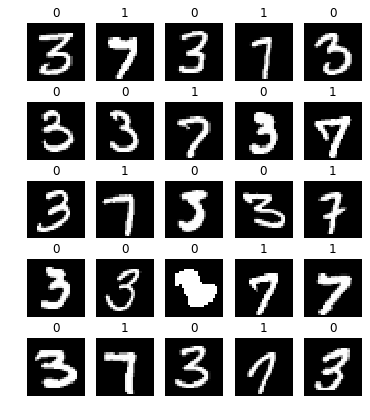

In [6]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

# Пояснения
### классу 0 соответствует цифра 3
### классу 1 соответствует цифра 7
#### Выбрал эти цифры, потому что на них хуже всего метрики

# Итерация по датасету
# А вот сюда стоит обратить внимание

In [7]:
for x, y in train_loader:
    break

## Размерность x
- 128 - размер батча
- 1 - количество каналов, у нас чернобелые картинки, поэтому канал 1
- 28 - количество пикселей в длину
- 28 - количество пикселей в ширину

In [8]:
x.shape

torch.Size([128, 1, 28, 28])

In [9]:
x

tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.424

## Просто выпрямим нашу матрицу в один вектор
### Для нашей игрушечной задачи для поучиться будет достаточно

In [10]:
x.view(x.shape[0], -1).numpy().shape

(128, 784)

In [11]:
for x, y in train_loader:
    x = x.view(x.shape[0], -1).numpy()
    y = y.numpy()
    break

In [12]:
x

array([[-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       ...,
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296]], dtype=float32)

### Размерность
- количество примеров в батче
- количество фичей

In [13]:
x.shape

(128, 784)

# Наши бинарные таргеты

In [14]:
y

array([0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0], dtype=int64)

In [15]:
# давайте ее исправим

In [16]:
y = np.expand_dims(y, 1)

In [17]:
y

array([[0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
    

In [18]:
x * y

array([[-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       ...,
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ]])

In [19]:
# исправили

# Итерация по эпохам

In [20]:
epochs = 3

for n_epoch in range(epochs):
    
    dataset_passed_samples = 0
    
    for x, y in train_loader:
        
        # вот здесь мы могли бы как-то манипулировать с данными, например, учить, но пока этого делать не будет
        
        time.sleep(0.05)
        
        dataset_passed_samples += x.shape[0]
        
        dataset_passed_percent = dataset_passed_samples * 100 / train_loader.dataset.data.shape[0]
        
        print(f'Эпоха - {n_epoch + 1}, прошли - {dataset_passed_percent:.2f} % датасета', end='\r')
        
    print('\r')

Эпоха - 1, прошли - 100.00 % датасета
Эпоха - 2, прошли - 100.00 % датасета
Эпоха - 3, прошли - 100.00 % датасета


# Давайте поучим пока не очень красиво нашу 2-х слойную нейронку

## 3 балла

### Шаги:
0. Задайте обучаемые параметры (TIP: np.random.rand) и скорость обучения для градиентного спуска.
1. Линейная трансформация через первый слой
1. Применение какой-нибудь нелийной функции активации
1. Линейная трансформация через второй слой
1. Примените какую-нибудь функцию, которая хорошая для бинарной классификации, чтобы перейти к вероятностям классов
1. Рассчитайте функцию потерь (бинарная кросс энтропия), не забудьте усреднить по батчу
1. Возьмите производные от функции потерь к каждому обучаемому параметру [видео про производные](https://youtu.be/tZ0yCzWfbZc)
1. Обновите веса w1, b1, w2, b2 с помощью градиентного спуска
1. Сохраняйте значения функции потерь и нарисуйте ее график

- TIP: количество входных фичей - 784 (28 пикселей * 28 пикселей)
- TIP: в шаге 0 домножьте w1, w2 на 0.01, а b1, b2 инициализируйте нулями
- TIP: в backward функции потерь по предсказаниям вашей модели нужно разделить еще на количество примеров в батче
- TIP: каждый следующий градиент рассчитывайте умножая на предыдущий

## Если вам сложно, сделайте сначала для одного слоя

In [124]:
### КОД СЮДА ###

learning_rate = 0.001
epochs = 1
rglrz = 0.01


def sigmoid(s):
    return 1/(1+np.exp(-s))

def bce(a, b):    
    return np.sum(-b * np.log(a) - (1 - b) * np.log(1 - a))/b.shape[0]

in_features = 784
out_features = 32

w1 = np.random.rand(in_features, out_features) * 0.01
b1 = np.zeros(out_features)
w2 = np.random.rand(out_features, 1) * 0.01
b2 = np.zeros(out_features)

losses = []

for n_epoch in range(epochs):
    
    print(f'Epoch: {n_epoch + 1}')
    
    for x, y in train_loader:        
        x = x.view(x.shape[0], -1).numpy()
        m = x.shape[0]
        mm = x.shape[1]
        
        y = np.expand_dims(y.numpy(), 1)
    
        ### КОД СЮДА ###        
        # forward
        z1 = x.dot(w1) + b1        
        a1 = sigmoid(z1)       
        z2 = a1.dot(w2) + b2 
        a2 = sigmoid(z2)
          
        # рассчет bce
        xntr = bce(a2, y)
       
        # backward       
#       d_loss/d_pred - градиент функции потерь по pred - (BATCH_SIZE, 1)
        d_loss_d_pred = -(y/a2 - ((1 - y)/(1-a2)))
#       d_pred/dz2 - градиент сигмоиды по z2 - (BATCH_SIZE, 1)

        d_pred_dz2 = d_loss_d_pred * (sigmoid(z2)*(1-sigmoid(z2)))
#       dz2/da1 - градиент линейного преобразования по a1 - (BATCH_SIZE, INNER_FEATURES)
        dz2_da1 = d_pred_dz2.dot(w2)
#       dz2/dw2 - градиент линейного преобразования по w2 - (INNER_FEATURES, 1)
        dz2_dw2 = dz2_da1.T.dot(a1)
#       dz2/db2 - градиент линейного преобразования по b2 - (1,)
        dz2_db2 = dz2_da1 * np.ones(b2.shape)
#       da1/dz1 - градиент нелинейной функции по z1 - (BATCH_SIZE, INNER_FEATURES)
        da1_dz1 = dz2_da1 *  sigmoid(z1)*(1-sigmoid(z1))
#       dz1/dw1 - градиент линейного преобразования по w1 - (IN_FEATURES, INNER_FEATURES)
        dz1_dw1 = da1_dz1.T.dot(x)
#       dz1/db1 - градиент линейного преобразования по b1 - (INNER_FEATURES,)
        dz1_db1 = da1_dz1 * np.ones(b1.shape)
      
    
#       dw1 = a1.T.dot(da1)/in_features
#       dw2 = a2.T.dot(da2)/out_features
        
        # gradient descent, with regularization
        w1 -= learning_rate * dz1_dw1.T + (rglrz/mm) * w1
        w2 -= learning_rate * dz2_dw2.T + (rglrz/mm) * w2
        
        b1 -= learning_rate * np.sum(dz2_db2, axis=0)
        b2 -= learning_rate * np.sum(dz1_db1, axis=0)
        
#       b2 = np.sum(da1)/m
#       b1 = np.sum(da2)/m                
        
        losses.append(xntr/x.shape[0])
        
        

Epoch: 1


## Подсказки по размерностям

### Forward

- z1 - первое линейное преобразование - (BATCH_SIZE, INNER_FEATURES)
- a1 - Применение нелинейности - (BATCH_SIZE, INNER_FEATURES)
- z2 - второе нелинейное преобразование - (BATCH_SIZE, 1)
- pred - сигмоида - (BATCH_SIZE, 1)
- loss - функция потерь - скаляр

### Backward

- d_loss/d_pred - градиент функции потерь по pred - (BATCH_SIZE, 1)
- d_pred/dz2 - градиент сигмоиды по z2 - (BATCH_SIZE, 1)
- dz2/da1 - градиент линейного преобразования по a1 - (BATCH_SIZE, INNER_FEATURES)
- dz2/dw2 - градиент линейного преобразования по w2 - (INNER_FEATURES, 1)
- dz2/db2 - градиент линейного преобразования по b2 - (1,)
- da1/dz1 - градиент нелинейной функции по z1 - (BATCH_SIZE, INNER_FEATURES)
- dz1/dw1 - градиент линейного преобразования по w1 - (IN_FEATURES, INNER_FEATURES)
- dz1/db1 - градиент линейного преобразования по b1 - (INNER_FEATURES,)

# Значение функции потерь на уровне 0.1 это уже выше 90% точности

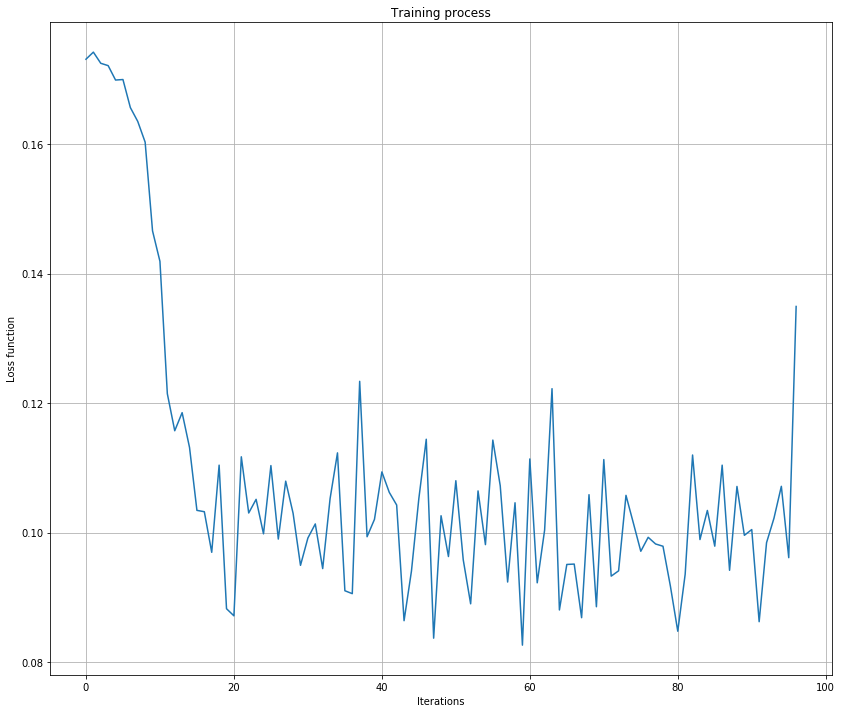

In [125]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function');

# По крутому

## 2 балла

# Импортируем нашу библиотеку

## Реализуйте такие слои:
- Linear - линейная трансформация (не забудьте, что у нас там как раз есть обучаемые параметры)
- ReLU
- BCELoss - Binary Cross Entropy


## Вы можете реализовать как здесь, так и в файла layers

- TIP: np.expand_dims(y, 1) для BCE, так как BCE на вход принимает просто вектор размерностью (батч сайз, )

## Также внутри layers есть код для Negative Log-Likelihood (сразу с софтмаксом)

In [23]:
from our_library import layers, wrapper, tools

# Пример, который мы разбирали в [видео про производные](https://youtu.be/tZ0yCzWfbZc)

In [24]:
class Sigmoid:

    def __init__(self):

        self._sigmoid_result = None

    def forward(self, x):

        self._sigmoid_result = 1 / (1 + np.exp(-x))

        return self._sigmoid_result

    def backward(self, grad):
        """
        :grad: градиент от предыдущего слоя
        :return: градиент для следующего слоя
        """

        new_grad = self._sigmoid_result * (1 - self._sigmoid_result) * grad

        return new_grad

    def step(self, learning_step):

        pass

# Пример работы тестов

In [25]:
x = np.array([[0.91551091, 0.15073826, 0.77137556, 0.59352491],
              [0.81126142, 0.1194849 , 0.29651178, 0.19066982]])

In [26]:
sigmoid_layer = Sigmoid()

In [27]:
forward_result = sigmoid_layer.forward(x)

In [28]:
correct_forward_result = np.array([[0.71412654, 0.53761337, 0.68381838, 0.64417351],
                                   [0.69237824, 0.52983574, 0.57358957, 0.54752357]])

In [29]:
# Must be close to zero
# -3.8713787731126104e-10
(correct_forward_result - forward_result).sum()

-3.8713787731126104e-10

In [30]:
backward_result = sigmoid_layer.backward(np.ones_like(x))

In [31]:
correct_backward_result = np.array([[0.20414982, 0.24858523, 0.2162108 , 0.229214  ],
                                    [0.21299061, 0.24910983, 0.24458457, 0.24774151]])

In [32]:
# Must be close to zero
# -1.7161740806237447e-08
(correct_backward_result - backward_result).sum()

-1.7161740806237447e-08

## Заготовка

In [33]:
class ReLU:

    def __init__(self):
        self.x = None
        pass

    def forward(self, x):
        self.x = x
        return np.maximum(x, 0, x)

    def backward(self, grad):       
        grad[self.x <= 0] = 0
#       (grad > 0) * 1
#       np.greater(grad, 0).astype(int)
        return grad

    def step(self, learning_rate):
        pass

In [34]:
class Linear:

    def __init__(self, in_features, out_features):
        
        # инициализируем веса
        self.weight = np.random.rand(in_features, out_features) * 0.01
        self.bias = np.zeros(out_features)
        
        # сохраняем градиент для весов
        self._grad_weight = None
        self._grad_bias = None
        
        self.x = None

    def forward(self, x):
        self.x  = x
        return x.dot(self.weight) + self.bias

    def backward(self, grad):       
        
        new_grad = grad.dot(self.weight.T)                

        self._grad_weight = np.dot(self.x.T, grad)                
        
        self._grad_bias = grad.mean(axis=0) * self.x.shape[0]
        
        return new_grad

    def step(self, learning_rate):
        self.weight -= learning_rate * self._grad_weight
        self.bias -= learning_rate * np.sum(self._grad_bias, axis=0)                
        pass

# Linear test

In [35]:
linear = Linear(in_features=4, out_features=3)

In [36]:
# так как внутри слоя мы объвяляем наши веса рандомно (домножая на 0.01), то давайте присвоим им для теста конкретные значения

linear.weight = np.array([[0.00879391, 0.0075844 , 0.00430709],
                          [0.00884834, 0.00921104, 0.00044317],
                          [0.00011441, 0.00822498, 0.00122346],
                          [0.00338301, 0.0001627 , 0.00711473]])

linear.bias = np.array([0., 0., 0.])

In [37]:
correct_forward_result = np.array([[0.01148086, 0.01477317, 0.00917651],
                                   [0.00887036, 0.00972334, 0.00526646]])

In [38]:
forward = linear.forward(x)

In [39]:
# Must be close to zero
# -1.2008401972449234e-09
(correct_forward_result - forward).sum()

-1.2008401937754765e-09

In [40]:
previous_grad = np.array([[0.01595814, 0.85148336, 0.9980065 ],
                          [0.73044998, 0.18287682, 0.41246361]])

In [41]:
correct_backward_result = np.array([[0.01089683, 0.00842654, 0.00822628, 0.00729307],
                                    [0.00958704, 0.00833055, 0.00209236, 0.00543544]])

In [42]:
backward = linear.backward(previous_grad)

In [43]:
# Must be close to zero
# 4.610488500960547e-09
(correct_backward_result - backward).sum()

4.6104884974911e-09

In [44]:
correct_grad_weight = np.array([[0.60719574, 0.92790321, 1.24830165],
                                [0.08968325, 0.15020214, 0.19972094],
                                [0.22889674, 0.71103859, 0.89213814],
                                [0.14874632, 0.54024567, 0.67098608]])

In [45]:
# Must be close to zero
# 2.0459672428474462e-09
(linear._grad_weight - correct_grad_weight).sum()

2.0459672428474462e-09

In [46]:
correct_grad_bias = np.array([0.74640812, 1.03436018, 1.41047011])

In [47]:
# Must be close to zero
# -2.220446049250313e-16
(linear._grad_bias - correct_grad_bias).sum()

-2.220446049250313e-16

# ReLU test

In [48]:
relu = ReLU()

In [49]:
x = np.array([[ 0.86811233, -0.23718669, -0.18401917, -0.37591633],
              [-0.40626018,  0.37746975, -0.46929233,  0.79067681]])

In [50]:
forward = relu.forward(x)

In [51]:
forward

array([[0.86811233, 0.        , 0.        , 0.        ],
       [0.        , 0.37746975, 0.        , 0.79067681]])

In [52]:
correct_forward_result = np.array([[0.86811233, 0.        , 0.        , 0.        ],
                                   [0.        , 0.37746975, 0.        , 0.79067681]])

In [53]:
# Must be close to zero
# 0.0
(forward - correct_forward_result).sum()

0.0

In [54]:
previous_grad = np.array([[0.22436157, 0.61897707, 0.67895832, 0.72428618],
                          [0.71231319, 0.87345215, 0.91129578, 0.90625846]])

In [55]:
correct_backward_result = np.array([[0.22436157, 0.        , 0.        , 0.        ],
                                    [0.        , 0.87345215, 0.        , 0.90625846]])

In [56]:
backward = relu.backward(previous_grad)

In [57]:
backward

array([[0.22436157, 0.        , 0.        , 0.        ],
       [0.        , 0.87345215, 0.        , 0.90625846]])

In [58]:
# Must be close to zero
# 0.0
(correct_backward_result - backward).sum()

0.0

# BCE test

### Не забудьте добавить np.expand_dims(y, 1) в forward

In [59]:
class BCELoss:

    def __init__(self):        
        self.x = None
        self.y = None
        pass

    def forward(self, x, y):
        y = np.expand_dims(y, 1)
        self.x = x
        self.y = y
        return bce(x,y)

    def backward(self):        
        return -(self.y/self.x - ((1 - self.y)/(1-self.x)))/y.shape[0]

    def step(self, learning_rate):
        pass

In [60]:
loss = BCELoss()

In [61]:
x = np.array([[0.76242307],
              [0.0908412 ],
              [0.60176646],
              [0.09606798]])

y = np.array([1, 0, 1, 0])

In [62]:
forward = loss.forward(x, y)

In [63]:
correct_forward_result = 0.24384403491500606

In [64]:
# Must be close to zero
# 0.0
(forward - correct_forward_result).sum()

0.0

In [65]:
backward = loss.backward()

In [66]:
backward

array([[-0.32790194],
       [ 0.27497946],
       [-0.41544356],
       [ 0.27656947]])

In [67]:
correct_backward_result = np.array([[-0.32790194],
                                    [ 0.27497946],
                                    [-0.41544356],
                                    [ 0.27656947]])

In [68]:
# Must be close to zero
# 1.051905440530021e-08
(backward - correct_backward_result).sum()

1.051905440530021e-08

## Реализуйте обертку над слоями - нейронную сеть
- TIP 1: modules - это список слоев, которые вы сделали выше. Порядок важен
- TIP 2: циклы это круто
- TIP 3: forward идет в одну сторону по слоям, а backward в другую
- TIP 4: В backward функции потерь мы не передаем предыдущий градиент, потому что это начало backward
- TIP 5: forward и backward ничего не должны отдавать
- TIP 6: в step нужно пройтись по всем слоям и обновить веса

In [69]:
class NeuralNetwork:

    def __init__(self, modules):        
        # список слоев
        self.modules  = modules
        self.out = None

    def forward(self, x):
        for m in self.modules:
            x = m.forward(x)
        self.out  = x
        return x

    def backward(self, grad):
        """
        :grad: градиент от функции потерь
        :return: возвращать ничего не потребуется
        """
        for m in self.modules[::-1]:
            grad = m.backward(grad)              
        pass

    def step(self, learning_rate):
        for m in self.modules:
            m.step(learning_rate) 
        pass

## Реализуйте обертку над моделью

In [70]:
class MNISTWrapper(wrapper.Wrapper):

    def __init__(self, model, loss, learning_rate=0.001, multi_class=False):

        # передаем параметры, чтобы отработал __init__ от наследуемого класса
        # можно было бы сделать через **kwargs, но сделал так для наглядности и чтобы были подсказки в юпитере

        super().__init__(model=model, loss=loss, learning_rate=learning_rate, multi_class=multi_class)

    def train_batch(self, x, y):
        """
        Нужно реализовать одну итерацию обучения модели:
        1. Рассчет forward
        2. Рассчет функции потерь
        3. Рассчет backward от функции потерь
        4. Рассчет backward по модели, передавая туда значение градиента по функции потерь
        5. Обновление весов с помощью step
        :param x: входные данные np.array with shape (batch_size, n_features)
        :param y: предсказания np.array with shape (batch_size, n_classes)
        :return:
        loss_batch - значение функции потерь, просто скаляр
        prediction - матрица предсказаний вашей модели

        напомню важные штуки, которые знает наш класс:
        self.model
        self.loss
        self.learning_rate
        """
        prediction = self.model.forward(x)        
        loss_batch = self.loss.forward(prediction, y)
        grad = self.loss.backward()
        self.model.backward(grad)
        self.model.step(learning_rate)
        return loss_batch, prediction
        

    def predict_batch(self, x):
        """
        Предсказание (aka inference) вашей модели:
        1. Рассчет forward
        :param x: входные данные np.array with shape (batch_size, n_features)
        :return: prediction - матрица предсказаний вашей модели
        """
        
        # Больше ничего делать не нужно
        # Все уже сделано
        
        return self.model.forward(x)

In [71]:
# задайте гиперпараметры
learning_rate = 0.0001
epochs = 3

# задайте слои в свою нейронную сеть, например, 3 слоя
# neural_network = layers.NeuralNetwork([Linear(in_features=4, out_features=3), ReLU()])
neural_network = NeuralNetwork(\
                [Linear(in_features=784, out_features=256), ReLU(), Linear(in_features=256, out_features=1), Sigmoid()])

# loss = layers.BCELoss()
loss = BCELoss()

In [72]:
classifier = MNISTWrapper(model=neural_network,
                          loss=loss,
                          learning_rate=learning_rate)

## Раскомментируйте и запустите

In [73]:
classifier.train(train_loader, test_loader, epochs=epochs)

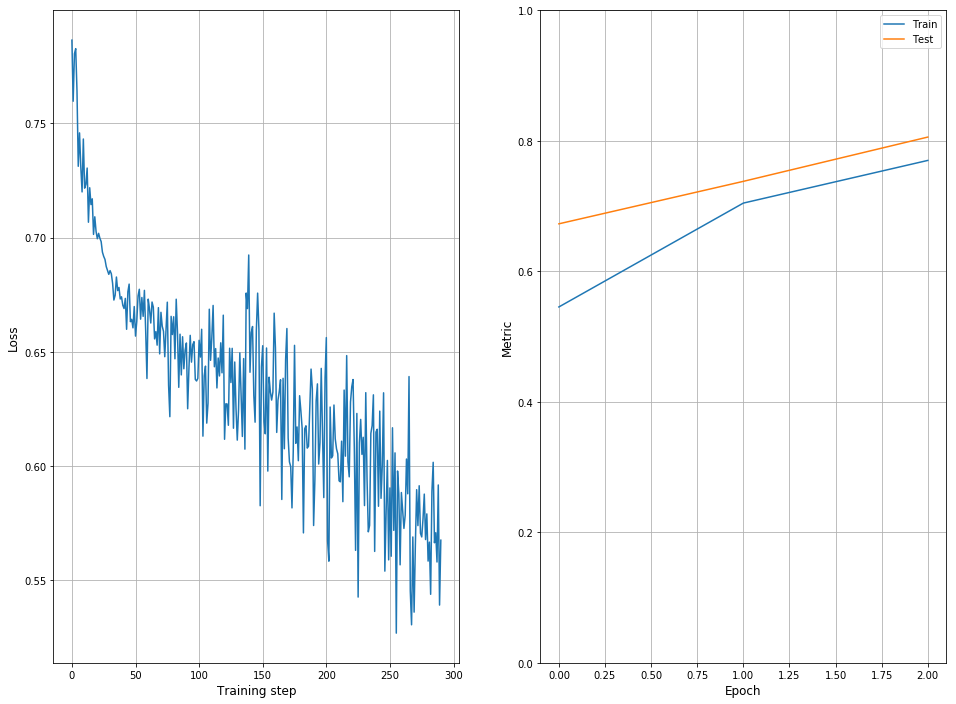

In [74]:
classifier.plot()

# Немного торча

In [75]:
import torch

### Мы можем определить нашу модель как последовательность уже существующих слоев, как в керасе

In [76]:
model = torch.nn.Sequential()

model.add_module(name='linear_1', module=torch.nn.Linear(in_features=784, out_features=256))
model.add_module(name='relu', module=torch.nn.ReLU())
model.add_module(name='linear_2', module=torch.nn.Linear(in_features=256, out_features=1))
model.add_module(name='sigmoid', module=torch.nn.Sigmoid())

model

Sequential(
  (linear_1): Linear(in_features=784, out_features=256, bias=True)
  (relu): ReLU()
  (linear_2): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

### Либо так

In [77]:
model = torch.nn.Sequential(
    torch.nn.Linear(in_features=784, out_features=256),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=256, out_features=1),
    torch.nn.Sigmoid()
)

model

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=1, bias=True)
  (3): Sigmoid()
)

## А вот для чего нужно было писать в домашке классы
## Для определения своих моделей/слоев/чего вам захочется нам нужно сделать такую структуру

In [78]:
# наследуемся от класса torch.nn.Module
class MLP(torch.nn.Module):
    
    # определяем метод __init__
    # он нужен для того, чтобы мы могли определить нужные нам слои, веса, сохраняемые операции
    # 
    # передаем ссылку на самого себя первым параметром
    # 
    # определяем любые другие передаваемые аргументы
    # могут быть чем угодно: числа, словари, другие слои, другие модели и вообще все что угодно
    # 
    def __init__(self, in_features, inner_features, out_features):
        
        # Главная задача этого метода - возможность использования в классе потомке, методов класса-родителя
        # Вызываем __init__ родителя - torch.nn.Module
        super().__init__()
        
        # определяем слои и все что захотим сохранять/использовать
        self.linear_1 = torch.nn.Linear(in_features=in_features, out_features=inner_features)
        self.non_linear_function = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(in_features=inner_features, out_features=out_features)
        self.sigmoid = torch.nn.Sigmoid()
        
    # нам нужно обязательно реализовать метод forward
    # это то, что нашей модели нужно делать, как оперировать с входными данными, как рассчитывать
    # метод backward нам не нужно реализовывать, потому что в торче есть автоматическое дифференцирование
    # главное, чтобы наши операции были дифференцируемы
    # некоторые подробности можете узнать здесь:
    # https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py
    # также список доступных дифференцируемых операций можете посмотреть здесь:
    # https://pytorch.org/docs/stable/tensors.html
    def forward(self, x):
        
        # наша привычная схема
        x = self.linear_1(x)
        x = self.non_linear_function(x)
        x = self.linear_2(x)
        x = self.sigmoid(x)
        
        return x
    
    # мы также можем реализовать любые другие полезные нам методы внутри класса

In [79]:
# определяем нашу модель
model = MLP(in_features=784, inner_features=256, out_features=1)

In [80]:
model

MLP(
  (linear_1): Linear(in_features=784, out_features=256, bias=True)
  (non_linear_function): ReLU()
  (linear_2): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [81]:
# можем посмотреть веса
model.linear_1.weight.shape

torch.Size([256, 784])

In [82]:
# еще нам нужно задать функцию потерь 
criterion = torch.nn.BCELoss()

In [83]:
# и оптимизатор, куда нужно передать параметры модели
# параметры модели можно взять методом класса .parameters()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

In [84]:
# можем посмотреть на параметры нашей модели
params = list(model.parameters())
params

[Parameter containing:
 tensor([[-0.0155, -0.0274, -0.0343,  ..., -0.0218, -0.0153,  0.0137],
         [-0.0237,  0.0116, -0.0013,  ..., -0.0073, -0.0228,  0.0103],
         [ 0.0173,  0.0055, -0.0211,  ..., -0.0176, -0.0229, -0.0200],
         ...,
         [ 0.0293,  0.0118,  0.0061,  ...,  0.0070,  0.0184, -0.0234],
         [-0.0165,  0.0059,  0.0055,  ...,  0.0010, -0.0060, -0.0141],
         [ 0.0059,  0.0059,  0.0141,  ..., -0.0046, -0.0211,  0.0059]],
        requires_grad=True), Parameter containing:
 tensor([-0.0291,  0.0342, -0.0251, -0.0161, -0.0046, -0.0184, -0.0019,  0.0225,
          0.0138,  0.0326,  0.0073,  0.0136,  0.0351,  0.0354, -0.0087, -0.0149,
         -0.0118,  0.0201, -0.0216,  0.0117, -0.0235, -0.0345, -0.0303,  0.0186,
         -0.0320,  0.0047, -0.0081,  0.0279, -0.0353, -0.0348,  0.0006,  0.0071,
          0.0301, -0.0067,  0.0121, -0.0127, -0.0183,  0.0146, -0.0299, -0.0271,
         -0.0035,  0.0047,  0.0267,  0.0327,  0.0157,  0.0289,  0.0140, -0.0204,

# Обучим нашу модель

In [85]:
# давайте сохранять значения нашей функции потерь каждую итерацию обучения
losses = []

# эта штука все еще отдает нам батчи данных
# мы поговорим про нее позже
for x, y in train_loader:

    x = x.view(x.shape[0], -1)
    y = y.unsqueeze(1).float()
    
    # обновим наши градиенты
    # будем делать это каждую итерацию обучения
    # потому что торч сохраняет в себе все градиенты пока не удалите таким образом рассчитанные градиенты
    # 
    # НЕОБЯЗАТЕЛЬНЫЕ ДЕТАЛИ
    # функция сохранения градиентов нужна для аккамуляции градиентов
    # например, когда нам не хватает памяти на большой батч
    # мы можем несколько раз прогнать forward на разных батчах
    # наши градиенты будут сохраняться
    # и только потом обновить через несколько итераций forward обновить наши веса
    # таким образом у нас получается больше батч
    # 
    optimizer.zero_grad()
    
    # 
    # предсказание нашей модели
    # здесь торч сам сохраняет необходимую информацию
    # чтобы понять эту логику у нас как раз и была часть домашки про собственные классы
    # 
    # торч строит динамический граф вычислений
    # то есть строит граф по тем операциям, которые вы определили в методе forward
    # 
    # то есть торч понимает, что вы сначала применили линейное преобразование
    # знает, где лежат веса для этого линейного преобразования
    # знает, что вы затем применили релу
    # затем опять линейное преобразование
    # затем сигмоиду
    # и вот таким образом торч выстроил граф
    # который нужен будет для backpropogation
    # 
    pred = model(x)
    
    # 
    # рассчитываем функцию потерь, добавляя в наш граф вычислений этот узел
    # 
    loss = criterion(pred, y.float())
    
    # 
    # вызываем метод backward() от нашей функции потерь (это крайний узел нашего графа вычислений)
    # этот метод проходит от конца графа в начало, вычисляя необходимые градиенты
    # передаем градиенты на следующие узлы
    # для весов сохраняет
    # 
    # то есть это почти то же самое, что мы делали в домашке с классами
    # 
    loss.backward()
    
    # 
    # теперь мы знаем необходимые градиенты и можем обновить веса с помощью градиентного спуска
    # 
    optimizer.step()
    
    # 
    # сохраним текущее значение функции потерь, чтобы потом могли посмотреть на график
    # очень важный момент: нам нужно отсоединить значение нашей фунции потерь от графа вычислений
    # чтобы граф не строился дальше на каждой итерации обучения
    # так мы рано или поздно переполним память
    # поэтому вызываем этот метод
    # работает для скаляров
    # 
    # для тензоров работает метод .tolist()
    # 
    current_loss_value = loss.item()
    losses.append(loss.item())

In [86]:
# Одна эпоха прошла

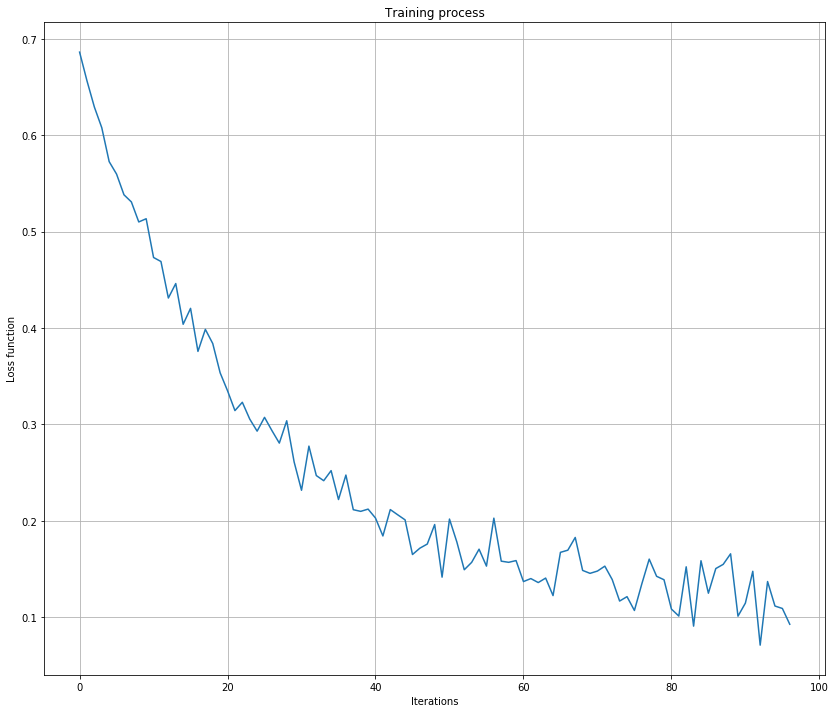

In [87]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function');

# Теперь мы можем что-то предсказать

In [88]:
for x, y in test_loader:

    x = x.view(x.shape[0], -1)
    y = y.unsqueeze(1).float()
    
    # чтобы не ходить по всему тестовому датасету, прекратим ходить после первой итерации
    break

In [89]:
x.shape

torch.Size([128, 784])

In [90]:
y.shape

torch.Size([128, 1])

In [91]:
# переходим в режим предсказания
# 
# позже в курсе мы разберем зачем конкретно это нужно
# 
# для искушенного нетерпеливого читателя: дропаут больше не дропаутит, батч норм больше не нормирует каждый батч
# а использует накопленную статистику при обучении и тд
# 
model.eval()

MLP(
  (linear_1): Linear(in_features=784, out_features=256, bias=True)
  (non_linear_function): ReLU()
  (linear_2): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [92]:
# этот контект позволяет не сохранять необходимую информацию для рассчета градиентов
with torch.no_grad():

    pred = model(x)

In [93]:
pred.shape

torch.Size([128, 1])

In [94]:
# избавимся от единичной размерности
pred = pred.squeeze()
y = y.squeeze()

In [95]:
pred.shape

torch.Size([128])

In [96]:
# таким образом из торчовых тензоров мы можем сделать нумпаевские массивы
pred = pred.numpy()
y = y.numpy()

In [97]:
y

array([1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1.,
       0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0.,
       1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1.,
       0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 1., 1., 0., 1., 0., 0., 1.], dtype=float32)

In [98]:
type(y)

numpy.ndarray

In [99]:
# бинаризируем наши предсказания
pred[pred > 0.5] = 1
pred[pred <= 0.5] = 0

In [100]:
# посчитаем метрику на батче
accuracy_score(y, pred)

0.96875

In [101]:
# заново определим нашу модель и выучимся несколько эпох
# будут уже новые параметры
model = MLP(in_features=784, inner_features=256, out_features=1)

criterion = torch.nn.BCELoss()
# мы позже поговорим про этот оптимизационный алгоритм
optimizer = torch.optim.Adam(params=model.parameters())

# Типичный цикл обучения с кучей сохранений лоссов

In [102]:
epochs = 10
losses = []
# нужно для early stopping, то есть трекать лучший лосс на валидации
best_test_loss = 10.

for n_epoch in range(epochs):
    
    train_losses = []
    test_losses = []
    test_preds = []
    test_targets = []
    
    progress_bar = tqdm(total=len(train_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))
    
    for x, y in train_loader:
        
        x = x.view(x.shape[0], -1)
        y = y.unsqueeze(1).float()
        
        optimizer.zero_grad()
        
        pred = model(x)
        
        loss = criterion(pred, y.float())
        
        loss.backward()
        
        optimizer.step()
        
        train_losses.append(loss.item())
        losses.append(loss.item())
        
        progress_bar.set_postfix(train_loss = np.mean(losses[-100:]))

        progress_bar.update(x.shape[0])
        
    progress_bar.close()
    
    for x, y in test_loader:
        
        x = x.view(x.shape[0], -1)
        y = y.unsqueeze(1).float()

        with torch.no_grad():
            
            pred = model(x)
            
        test_preds.append(pred.numpy())
        test_targets.append(y.numpy())

        loss = criterion(pred, y)

        test_losses.append(loss.item())
        
    mean_test_loss = np.mean(test_losses)
        
    print('Losses: train - {:.3f}, test = {:.3f}'.format(np.mean(train_losses), mean_test_loss))
    
    test_preds = np.concatenate(test_preds)
    test_preds = test_preds.squeeze()
    test_targets = np.concatenate(test_targets).squeeze()
    
    test_preds[test_preds > 0.5] = 1
    test_preds[test_preds <= 0.5] = 0
    
    accurary = accuracy_score(test_targets, test_preds)

    print('Test: accuracy - {:.3f}'.format(accurary))
        
    # как раз early stopping
    # то есть: если наша функция потерь на валидационном датасете стала расти, то прекращаем обучение
    # рост фунции потерь на валидационном датасете говорит о переобучении
    # пожалуй, самый популярный метод валидации для нейронных сетей
    if mean_test_loss < best_test_loss:
        best_test_loss = mean_test_loss
    else:
        print('Early stopping')
        break    

Epoch 1: 100%|██████████████████████████████████████████████| 12396/12396 [00:07<00:00, 1550.38it/s, train_loss=0.0687]


Losses: train - 0.069, test = 0.046
Test: accuracy - 0.986


Epoch 2: 100%|██████████████████████████████████████████████| 12396/12396 [00:09<00:00, 1343.95it/s, train_loss=0.0273]


Losses: train - 0.027, test = 0.031
Test: accuracy - 0.989


Epoch 3: 100%|██████████████████████████████████████████████| 12396/12396 [00:08<00:00, 1418.55it/s, train_loss=0.0176]


Losses: train - 0.017, test = 0.022
Test: accuracy - 0.991


Epoch 4: 100%|██████████████████████████████████████████████| 12396/12396 [00:06<00:00, 1772.02it/s, train_loss=0.0103]


Losses: train - 0.010, test = 0.025
Test: accuracy - 0.992
Early stopping


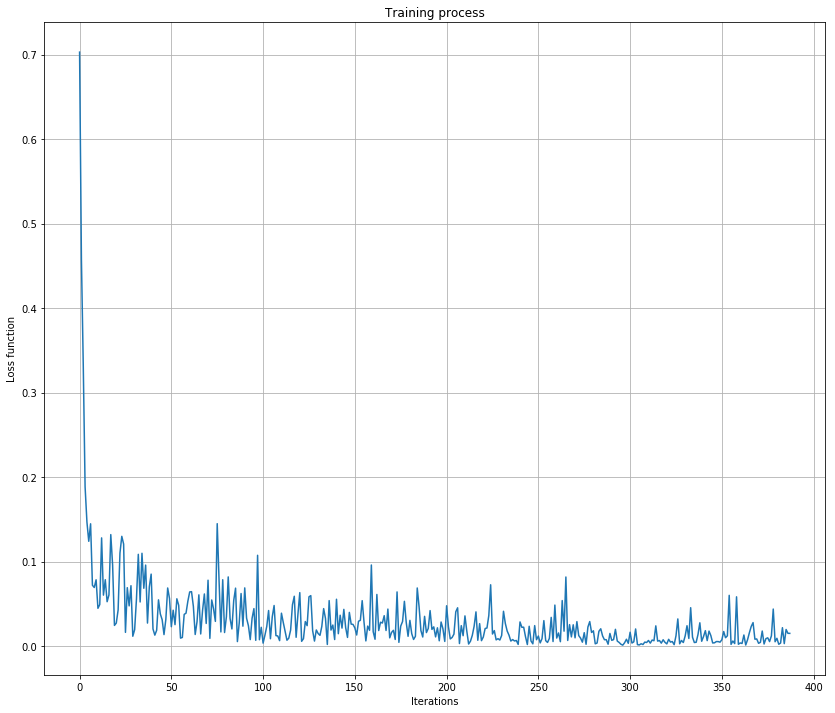

In [103]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function');

# One more deeper
## Пойдем глубже раскрывать суть лего в глубоком обучении
Атомарной частью торча является ```torch.nn.Parameter``` - обучаемый вес.  
По сути это такой же тензор, но только мы говорим торчу, что мы хотим, чтобы торч сохранял градиент для этого веса, 
чтобы обновить его при градиентном шаге оптимизатора

```torch.nn.Parameter(data=None, requires_grad=True)```  
В дефолтном варианте для тензора мы не требуем сохранять градиент, но можем потребовать и тогда наш тензор станет обучаемым весом  
```tensor(data, dtype=None, device=None, requires_grad=False)```

In [104]:
parampampam = torch.nn.Parameter(torch.rand(50))
parampampam

Parameter containing:
tensor([0.3741, 0.6206, 0.9721, 0.3034, 0.1269, 0.9776, 0.6494, 0.2895, 0.3054,
        0.9041, 0.9664, 0.8906, 0.8795, 0.9926, 0.8034, 0.5103, 0.8944, 0.9875,
        0.1586, 0.0260, 0.8431, 0.2641, 0.7191, 0.9977, 0.7569, 0.3537, 0.6810,
        0.3255, 0.6693, 0.2004, 0.1824, 0.2855, 0.5688, 0.8909, 0.1839, 0.6940,
        0.6040, 0.3326, 0.3058, 0.3396, 0.8905, 0.1099, 0.9148, 0.0685, 0.5217,
        0.9942, 0.5931, 0.1936, 0.2643, 0.1592], requires_grad=True)

In [105]:
x = torch.rand(32, 50)

In [106]:
result = parampampam - x

In [107]:
result

tensor([[ 0.3479,  0.2746,  0.5417,  ..., -0.0890, -0.2688, -0.5078],
        [-0.6201, -0.3489,  0.6000,  ..., -0.6631, -0.7256,  0.0169],
        [-0.0906,  0.2812,  0.6790,  ..., -0.2697,  0.1187, -0.6789],
        ...,
        [ 0.3410, -0.3361,  0.1316,  ..., -0.0570, -0.3480,  0.1584],
        [-0.5730,  0.6034,  0.8016,  ..., -0.5295, -0.6937, -0.6580],
        [ 0.1279,  0.3547, -0.0271,  ...,  0.0183, -0.6446, -0.1178]],
       grad_fn=<SubBackward0>)

### Можно заметить, что у тензора result теперь есть атрибут grad_fn
Это функция, по которой нужно рассчитывать градиент  
И это говорит о том, что теперь у нас есть граф вычислений

In [108]:
result.grad_fn

### И мы можем продолжать наш граф

In [109]:
result_end = torch.sigmoid(result)

In [110]:
result_end

tensor([[0.5861, 0.5682, 0.6322,  ..., 0.4778, 0.4332, 0.3757],
        [0.3498, 0.4137, 0.6457,  ..., 0.3401, 0.3262, 0.5042],
        [0.4774, 0.5698, 0.6635,  ..., 0.4330, 0.5296, 0.3365],
        ...,
        [0.5844, 0.4167, 0.5328,  ..., 0.4857, 0.4139, 0.5395],
        [0.3606, 0.6464, 0.6903,  ..., 0.3706, 0.3332, 0.3412],
        [0.5319, 0.5878, 0.4932,  ..., 0.5046, 0.3442, 0.4706]],
       grad_fn=<SigmoidBackward>)

### Для примера того, когда у нас граф не строится
Когда нам нечего оптимизировать!

In [111]:
z = torch.rand(50)

In [112]:
result_2 = torch.sigmoid(z - x)

In [113]:
result_2

tensor([[0.4976, 0.5324, 0.6022,  ..., 0.5879, 0.5475, 0.5006],
        [0.2733, 0.3790, 0.6160,  ..., 0.4455, 0.4339, 0.6288],
        [0.3898, 0.5341, 0.6345,  ..., 0.5435, 0.6407, 0.4579],
        ...,
        [0.4958, 0.3820, 0.5011,  ..., 0.5956, 0.5278, 0.6612],
        [0.2828, 0.6127, 0.6625,  ..., 0.4787, 0.4417, 0.4631],
        [0.4428, 0.5523, 0.4615,  ..., 0.6136, 0.4539, 0.5969]])

In [114]:
# нет ссылки на функцию, по которой можем рассчитать градиент
print(result_2.grad_fn)

None


# Обучаемые веса
## Теперь мы знаем, что можем сами задавать веса
Так давайте сделаем свой класс для линейного преобразования

In [115]:
class MyLinear(torch.nn.Module):
    
    def __init__(self, in_features, out_features):
        
        super().__init__()
        
        # задаем матрицу весов и смещение
        self.weight = torch.nn.Parameter(torch.rand(in_features, out_features) * 0.01)
        self.bias = torch.nn.Parameter(torch.zeros(out_features))
        
    def forward(self, x):
        
        return torch.matmul(x, self.weight) + self.bias

## Вот таким образом можно написать свои функции и то, как их дифференцировать
На практике встречается супер редко

In [116]:
class MyReLU(torch.autograd.Function):

    @staticmethod
    def forward(ctx, x):

        ctx.save_for_backward(x)
        
        return x.clamp(min=0)

    @staticmethod
    def backward(ctx, grad_output):

        x, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[x < 0] = 0
        
        return grad_input

In [117]:
class MLP(torch.nn.Module):
    
    def __init__(self, in_features, inner_features, out_features):
        
        super().__init__()
        
        # слои определяются также как обычно
        self.linear_1 = MyLinear(in_features=in_features, out_features=inner_features)
        # обратите внимание как определяется своя функция
        self.non_linear = MyReLU.apply
        self.linear_2 = MyLinear(in_features=inner_features, out_features=out_features)
        # еще один момент:
        # мы сознательно не определяем сигмоиду
        # 
        # Почему?
        # В торче для NLL и Binary Cross Entropy 
        # есть более оптимальные слои, которые используют некоторые оптимизационные трюки
        # рассчитываются быстрее и стабильнее
        # 
        
    def forward(self, x):
        
        x = self.linear_1(x)
        x = self.non_linear(x)
        x = self.linear_2(x)
        
        return x

In [118]:
model = MLP(784, 256, 1)

In [119]:
model

MLP(
  (linear_1): MyLinear()
  (linear_2): MyLinear()
)

In [120]:
# вот оптимизация для BCE 
# эта функция потерь объединяет в себе сигмоиду и BCE
# и решает задачу более эффективно

# 
# Для NLLLoss есть это CrossEntropy: https://pytorch.org/docs/stable/nn.html#crossentropyloss
# 
# 
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters())

In [121]:
# определим функцию для сигмоиды, чтобы использовать при тестировании
def sigmoid(x):
    
    return 1 / (1 + np.exp(-x))

In [122]:
epochs = 10
losses = []
best_test_loss = 10.

for n_epoch in range(epochs):
    
    train_losses = []
    test_losses = []
    test_preds = []
    test_targets = []
    
    progress_bar = tqdm(total=len(train_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))
    
    for x, y in train_loader:
        
        x = x.view(x.shape[0], -1)
        y = y.unsqueeze(1).float()
        
        optimizer.zero_grad()
        
        pred = model(x)
        
        loss = criterion(pred, y.float())
        
        loss.backward()
        
        optimizer.step()
        
        train_losses.append(loss.item())
        losses.append(loss.item())
        
        progress_bar.set_postfix(train_loss = np.mean(losses[-100:]))

        progress_bar.update(x.shape[0])
        
    progress_bar.close()
    
    for x, y in test_loader:
        
        x = x.view(x.shape[0], -1)
        y = y.unsqueeze(1).float()

        with torch.no_grad():
            
            pred = model(x)
            
        test_preds.append(pred.numpy())
        test_targets.append(y.numpy())

        loss = criterion(pred, y)

        test_losses.append(loss.item())
        
    print('Losses: train - {:.3f}, test = {:.3f}'.format(np.mean(train_losses), np.mean(test_losses)))
    
    test_preds = np.concatenate(test_preds)
    # Применяем сигмоиду
    test_preds = sigmoid(test_preds.squeeze())
    test_targets = np.concatenate(test_targets).squeeze()
    
    test_preds[test_preds > 0.5] = 1
    test_preds[test_preds <= 0.5] = 0
    
    accurary = accuracy_score(test_targets, test_preds)

    print('Test: accuracy - {:.3f}'.format(accurary))
        
    if np.mean(test_losses) < best_test_loss:
        best_test_loss = np.mean(test_losses)
    else:
        print('Early stopping')
        break    

Epoch 1: 100%|███████████████████████████████████████████████| 12396/12396 [00:07<00:00, 1660.23it/s, train_loss=0.205]


Losses: train - 0.205, test = 0.060
Test: accuracy - 0.979


Epoch 2: 100%|██████████████████████████████████████████████| 12396/12396 [00:08<00:00, 1462.74it/s, train_loss=0.0429]


Losses: train - 0.042, test = 0.051
Test: accuracy - 0.985


Epoch 3: 100%|██████████████████████████████████████████████| 12396/12396 [00:07<00:00, 1565.66it/s, train_loss=0.0319]


Losses: train - 0.032, test = 0.044
Test: accuracy - 0.985


Epoch 4: 100%|██████████████████████████████████████████████| 12396/12396 [00:06<00:00, 1886.36it/s, train_loss=0.0247]


Losses: train - 0.025, test = 0.034
Test: accuracy - 0.989


Epoch 5: 100%|██████████████████████████████████████████████| 12396/12396 [00:06<00:00, 1852.81it/s, train_loss=0.0179]


Losses: train - 0.018, test = 0.026
Test: accuracy - 0.991


Epoch 6: 100%|███████████████████████████████████████████████| 12396/12396 [00:06<00:00, 1882.92it/s, train_loss=0.012]


Losses: train - 0.012, test = 0.021
Test: accuracy - 0.992


Epoch 7: 100%|█████████████████████████████████████████████| 12396/12396 [00:06<00:00, 1836.61it/s, train_loss=0.00809]


Losses: train - 0.008, test = 0.023
Test: accuracy - 0.992
Early stopping
